In [ ]:
!pip install -q pandas spacy textblob transformers torch

# Download spaCy English model
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 95.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import spacy
from textblob import TextBlob
from transformers import pipeline


In [ ]:
df = pd.read_csv("all_reviews.csv")

# Basic inspection
print(df.shape)
df.head()

(1003, 9)


,source,retailer,product_id,product_name,rating,submission_time,user_nickname,review_text,price
0,bazaarvoice,sephora_ca,2558328,Dior Forever Skin Glow,1,2025-10-20 01:06:41+00:00,Alaa71,they sold items used before never buy online i...,77 CAD
1,bazaarvoice,sephora_ca,2558047,Dior Forever Skin Glow,1,2025-09-30 23:06:18+00:00,BrettC,"I was colour matched in the store, but I thoug...",77 CAD
2,bazaarvoice,sephora_ca,2558062,Dior Forever Skin Glow,5,2025-09-16 22:58:22+00:00,computerface21,"WOW. Great coverage but doesn't look ""cakey"" ...",77 CAD
3,bazaarvoice,sephora_ca,2557999,Dior Forever Skin Glow,5,2025-09-16 02:56:02+00:00,PandaMochi,I think I may have found my holy grail foundat...,77 CAD
4,bazaarvoice,sephora_ca,2558054,Dior Forever Skin Glow,5,2025-08-16 03:04:05+00:00,pbutter234,Absolutely loving it. It gives such a smooth a...,77 CAD


In [ ]:
df = df.dropna(subset=['review_text'])
df = df[df['review_text'].str.strip() != '']

print(df.shape)

(1000, 9)


In [ ]:
df = df[df["review_text"].str.strip() != ""]

df["review_text"] = df["review_text"].astype(str).str.lower()


,source,retailer,product_id,product_name,rating,submission_time,user_nickname,review_text,price
0,bazaarvoice,sephora_ca,2558328,Dior Forever Skin Glow,1,2025-10-20 01:06:41+00:00,Alaa71,they sold items used before never buy online i...,77 CAD
1,bazaarvoice,sephora_ca,2558047,Dior Forever Skin Glow,1,2025-09-30 23:06:18+00:00,BrettC,"i was colour matched in the store, but i thoug...",77 CAD
2,bazaarvoice,sephora_ca,2558062,Dior Forever Skin Glow,5,2025-09-16 22:58:22+00:00,computerface21,"wow. great coverage but doesn't look ""cakey"" ...",77 CAD


# 1. TextBlob — Sentence-Level Polarity Attempt

In [ ]:
nlp = spacy.load("en_core_web_sm")

def extract_pros_cons(text):
    doc = nlp(text)
    pros, cons = [], []

    for sent in doc.sents:
        polarity = TextBlob(sent.text).sentiment.polarity
        if polarity > 0.2:
            pros.append(sent.text.strip())
        elif polarity < -0.2:
            cons.append(sent.text.strip())

    return " | ".join(pros), " | ".join(cons)

df["pros"], df["cons"] = zip(*df["review_text"].apply(extract_pros_cons))

# Preview results
df[["review_text", "pros", "cons"]].head(10)

,review_text,pros,cons
0,they sold items used before never buy online i...,,
1,"i was colour matched in the store, but i thoug...","i was colour matched in the store, but i thoug...",
2,"wow. great coverage but doesn't look ""cakey"" ...","great coverage but doesn't look ""cakey"" at all...",i usually can't wait to finish work and take ...
3,i think i may have found my holy grail foundat...,"i first bought lancome, it was alright | but i...",
4,absolutely loving it. it gives such a smooth a...,absolutely loving it. | i find it to be the sa...,
5,my skin is dry so it's difficult to me to find...,,my skin is dry so it's difficult to me to find...
6,"best foundation ever! the color is perfect, le...","best foundation ever! | the color is perfect, ...",
8,this foundation is the best i’ve tried so far....,this foundation is the best i’ve tried so far....,
9,the dior forever skin foundation was a disappo...,"it felt overly oily on my skin, oxidized signi...",the dior forever skin foundation was a disappo...
10,worn this a couple times but noticed it left m...,,


# 2. FLAN-T5 — Few-Shot Summarization Attempt

In [ ]:

aspect_extractor = pipeline("text2text-generation", model="google/flan-t5-base")

def t5_extract(text):
    prompt = f"Extract pros and cons from this review:\n{text}"
    output = aspect_extractor(prompt, max_new_tokens=60)[0]["generated_text"]
    return output

# Run on a few samples to test
df_sample = df.sample(5, random_state=42)
df_sample["pros_cons_summary"] = df_sample["review_text"].apply(t5_extract)

# Split into columns if formatted like "Pros: ... Cons: ..."
df_sample[["pros", "cons"]] = df_sample["pros_cons_summary"].str.extract(r"Pros:(.*)Cons:(.*)", expand=True)
df_sample[["review_text", "pros", "cons"]]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


,review_text,pros,cons
523,superrr...perfect🖤love it.estee lauder👌3n2 whe...,NaN,NaN
739,i have been using estée lauder for years and s...,NaN,NaN
742,perfect for covering imperfections. stays and ...,NaN,NaN
662,the double wear foundation is the best i have ...,NaN,NaN
412,"i do get hormonal breakouts at times (i'm 53),...",NaN,NaN


/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  plt.savefig(
/usr/local/lib/python3.12/dist-packages/google/colab/_quickchart_lib.py:32: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('review_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128420 (\N{BLACK HEART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128076 (\N{OK HAND SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


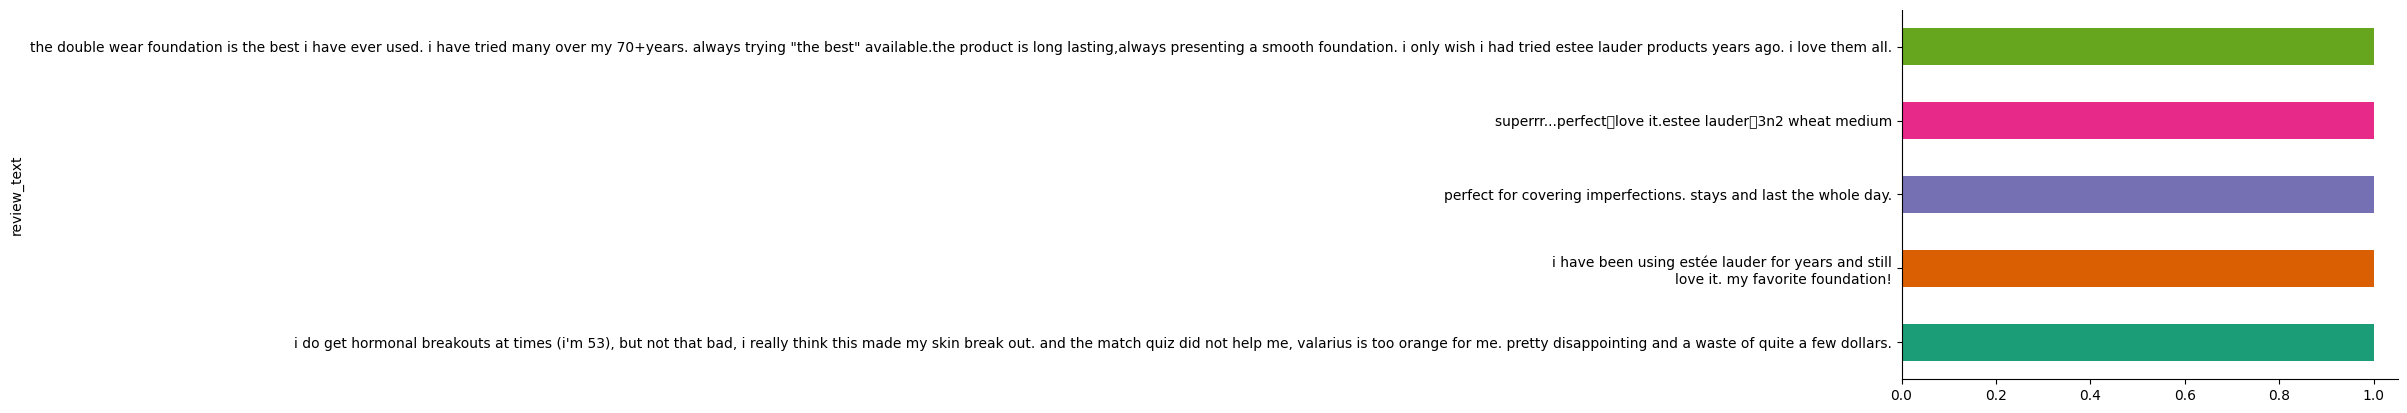

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('review_text').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# 3. VADER — Rule-Based Sentiment Experiment

In [ ]:
# Install and import libraries
!pip install -q vaderSentiment spacy textblob
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

nlp = spacy.load("en_core_web_sm")
analyzer = SentimentIntensityAnalyzer()

def extract_pros_cons_vader(text):
    doc = nlp(text)
    pros, cons = [], []

    for sent in doc.sents:
        sentiment = analyzer.polarity_scores(sent.text)
        compound = sentiment["compound"]

        # classify sentences based on sentiment polarity
        if compound >= 0.05:
            pros.append(sent.text.strip())
        elif compound <= -0.05:
            cons.append(sent.text.strip())

    # fallback: if neither found, classify entire review based on overall sentiment
    overall = analyzer.polarity_scores(text)["compound"]
    if not pros and not cons:
        if overall >= 0.05:
            pros.append(text.strip())
        elif overall <= -0.05:
            cons.append(text.strip())

    return " | ".join(pros), " | ".join(cons)

# Apply function to reviews
df["pros"], df["cons"] = zip(*df["review_text"].astype(str).apply(extract_pros_cons_vader))

# Preview
df[["review_text", "pros", "cons"]].head(10)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 10.9 MB/s eta 0:00:00


,review_text,pros,cons
0,they sold items used before never buy online i...,,
1,"i was colour matched in the store, but i thoug...","i was colour matched in the store, but i thoug...",
2,"wow. great coverage but doesn't look ""cakey"" ...","wow. | great coverage but doesn't look ""cakey""...",
3,i think i may have found my holy grail foundat...,"i first bought lancome, it was alright | but i...",it was a long struggle as i was deciding betwe...
4,absolutely loving it. it gives such a smooth a...,absolutely loving it. | i will say try the sha...,
5,my skin is dry so it's difficult to me to find...,,my skin is dry so it's difficult to me to find...
6,"best foundation ever! the color is perfect, le...","best foundation ever! | the color is perfect, ...",
8,this foundation is the best i’ve tried so far....,this foundation is the best i’ve tried so far....,
9,the dior forever skin foundation was a disappo...,"it felt overly oily on my skin, oxidized signi...",the dior forever skin foundation was a disappo...
10,worn this a couple times but noticed it left m...,,worn this a couple times but noticed it left m...


# Generate

In [ ]:


# Load FLAN-T5 model (zero-shot text2text generation)
generator = pipeline("text2text-generation", model="google/flan-t5-base", device_map="auto")

def generate_pros_cons(text):
    prompt = (
        "You are analyzing a product review. "
        "Summarize it as clear pros and cons. "
        "Write in the format:\n"
        "Pros: ...\nCons: ...\n"
        f"Review: {text}"
    )

    output = generator(prompt, max_new_tokens=100)[0]["generated_text"]

    pros, cons = "", ""
    if "Pros:" in output and "Cons:" in output:
        parts = output.split("Cons:")
        pros = parts[0].replace("Pros:", "").strip()
        cons = parts[1].strip()
    else:
        # Fallback: store full output in pros if model didn’t follow format
        pros = output

    return pros, cons

# Run on a small subset first (generation is slow)
sample_df = df.sample(5, random_state=42).copy()
sample_df["pros"], sample_df["cons"] = zip(*sample_df["review_text"].apply(generate_pros_cons))

sample_df[["review_text", "pros", "cons"]]


Device set to use cuda:0


,review_text,pros,cons
523,superrr...perfect🖤love it.estee lauder👌3n2 whe...,Pros: ...superrr...perfectlove it.estee lauder...,
739,i have been using estée lauder for years and s...,...,... I have been using Estée Lauder for years a...
742,perfect for covering imperfections. stays and ...,Pros: ...Pros: ...Pros: ...Pros: ...Pros: ...P...,
662,the double wear foundation is the best i have ...,...,... Review: the double wear foundation is the ...
412,"i do get hormonal breakouts at times (i'm 53),...",...,... Review: I do get hormonal breakouts at tim...


In [ ]:

generator = pipeline("text2text-generation", model="google/flan-t5-base", device_map="auto")

def generate_pros_cons_clean(text):
    prompt = (
        "Summarize this product review into clear pros and cons.\n"
        "Return only in the format:\n"
        "Pros: <list of pros>\nCons: <list of cons>\n\n"
        f"Review: {text}"
    )

    output = generator(prompt, max_new_tokens=100, num_beams=4)[0]["generated_text"]

    # --- clean up model output ---
    output = output.replace("Review:", "").replace("review:", "")
    output = output.replace("Pros: Pros:", "Pros:").replace("Cons: Cons:", "Cons:")
    output = output.strip()

    # --- split pros and cons ---
    pros, cons = "", ""
    if "Pros:" in output and "Cons:" in output:
        parts = output.split("Cons:")
        pros = parts[0].replace("Pros:", "").strip(" .:-")
        cons = parts[1].strip(" .:-")
    else:
        pros = output.strip(" .:-")

    return pros, cons

# Run on a subset first (try 10 to preview)
sample_df = df.sample(10, random_state=42).copy()
tqdm.pandas()
sample_df["pros"], sample_df["cons"] = zip(*sample_df["review_text"].progress_apply(generate_pros_cons_clean))

sample_df[["review_text", "pros", "cons"]]


Device set to use cuda:0


  0%|          | 0/10 [00:00<?, ?it/s]

,review_text,pros,cons
523,superrr...perfect🖤love it.estee lauder👌3n2 whe...,Pros: list of pros> list of cons> list of cons...,
739,i have been using estée lauder for years and s...,Pros: list of pros> list of cons> list of cons...,
742,perfect for covering imperfections. stays and ...,Pros: list of pros> list of cons> list of cons...,
662,the double wear foundation is the best i have ...,Pros: list of pros> list of cons> list of cons...,
412,"i do get hormonal breakouts at times (i'm 53),...",Pros: list of pros> list of cons> list of cons...,
680,great foundation! stays on place for the whole...,Pros: list of pros> list of cons> list of cons...,
628,i've been using estée lauder double wear for y...,Pros: list of pros> list of cons> list of cons...,
514,this is the foundation that makes the makeup l...,Pros: list of pros> list of cons> list of cons...,
862,love this! broke out with another brand so whe...,Pros: list of pros> list of cons> list of cons...,
137,this is so cakey and made me break out worse t...,I don't know if it's a good product or if it's...,
